# Exploring federal-wiretaps collated data

This notebook shows how to get started with pandas and the `data/collated/federal-wiretaps.csv` data.



In [33]:
import pandas as pd
from pathlib import Path

pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline
plt.style.use('fivethirtyeight')

DATA_DIR = Path('data/collated/')
SRCDATA_PATH = DATA_DIR / 'federal-wiretaps.csv'

In [2]:
records = pd.read_csv(SRCDATA_PATH)
len(records)

16569

## Cleaning it up some

In [3]:
## Isolating the years into a column
records['year'] = records['filename'].str.extract(r"(\d+)").astype(str)

In [4]:
## Getting rid of an arbitrary column that repeats the column names
records = records[records.year != 'nan']

## Figuring out the states + geocoding

In [5]:
states = pd.read_csv("data/collated/us-state-capitals.csv")

In [6]:
states.state = states.state.str.upper()

In [7]:
def get_states(x):
    for state in states.state:
        if x.Jurisdiction.find(state) > -1:
            return state

In [8]:
records['state'] = records.apply(get_states, axis=1)

In [9]:
records = records.merge(states, on='state')

## Adding some categories to make things go smoother

In [10]:
## Giving some categories to make it a bit easier to digest

def build_cats(x):
    
    # Drugs is defined as an offense pertaining mostly to drugs
    if x.isin(['NARCOTICS','DRUGS','DRUGS - ILLEGAL','DRUGS - PRESCRIPTION']).Offense:
        return 'Drugs'
    
    # Violence is defined as any offense that results in harm to a person's body or property
    if x.isin(['MURDER','HUMAN/SEX TRAFFICKING','KIDNAPPING','HOSTAGE TAKING','TERRORISM','ASSAULT','BOMBING','ARSON','INTIMIDATION','FIREARMS','INTIMIDATION']).Offense:
        return 'Violence'
    
    # Money is defined as any offense that has the primary intention of gaining money through unlawful means
    if x.isin(['RACKATEERING','COERCION','COUNTERFEITING','EMBEZZLEMENT','MONEY LAUNDERING','$LAUNDERING','GAMBLING','BRIBERY','FRAUD','EXTORTION','LOANSHARKING','USURY', 'THEFT','ROBBERY','SMUGGLING','POSSESSION']).Offense:
        return 'Money'
    
    # Civil is defined as pertaining to social and cultural issues
    if x.isin(['IMMIGRATION','CIVIL RIGHTS','CORRUPTION']).Offense:
        return 'Civil'
    
    # Conspiracy is vague in this, so I'm not sure how to place it
    if x.Offense == 'CONSPIRACY':
        return 'Conspiracy'
    
    # Other is taken as other, or as the too-vague-to-define values
    if x.isin(['OTHER','TRANSPORT','INTERFERENCE']).Offense:
        return 'Other'


records['category'] = records.apply(build_cats, axis=1)
records.category.value_counts()

Drugs         13252
Conspiracy     1483
Money           719
Violence        205
Civil           128
Other            90
Name: category, dtype: int64

## Adding state populations in
`Narcotics wiretapping per capita`

In [11]:
## estimates from the U.S. Census Bureau : https://www2.census.gov/programs-surveys/popest/datasets/2010-2018/state/asrh/

pops = pd.read_csv("data/collated/scprc-est2018-18+pop-res.csv")

In [12]:
pops.NAME = pops.NAME.str.upper()

In [13]:
records.groupby(by='year').state.nunique()

year
2013    45
2014    45
2015    46
2016    47
2017    44
2018    45
Name: state, dtype: int64

In [14]:
drugs = records[(records.category=='Drugs') & (records.year == '2018')].state.value_counts().reset_index()

In [15]:
drugs = drugs.merge(pops, left_on='index', right_on='NAME')

In [16]:
drugs.head()

,index,state,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2018,POPEST18PLUS2018,PCNT_POPEST18PLUS
0,CALIFORNIA,275,40,4,9,6,CALIFORNIA,39557045,30567090,77.3
1,NEW YORK,222,40,1,2,36,NEW YORK,19542209,15474107,79.2
2,NEW JERSEY,112,40,1,2,34,NEW JERSEY,8908520,6954877,78.1
3,TEXAS,108,40,3,7,48,TEXAS,28701845,21303746,74.2
4,ILLINOIS,98,40,2,3,17,ILLINOIS,12741080,9883814,77.6


In [17]:
drugs['per_capita'] = (drugs['state'] / drugs['POPESTIMATE2018']) * 1000000

In [18]:
drugs = drugs.merge(states, left_on='index', right_on='state')

In [19]:
drugs.NAME.value_counts().sum()

45

In [20]:
drugs.head()

,index,state_x,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2018,POPEST18PLUS2018,PCNT_POPEST18PLUS,per_capita,state_y,description,Latitude,Longitude
0,CALIFORNIA,275,40,4,9,6,CALIFORNIA,39557045,30567090,77.3,6.951985,CALIFORNIA,Sacramento,38.576668,-121.493629
1,NEW YORK,222,40,1,2,36,NEW YORK,19542209,15474107,79.2,11.360026,NEW YORK,Albany,42.652843,-73.757874
2,NEW JERSEY,112,40,1,2,34,NEW JERSEY,8908520,6954877,78.1,12.572234,NEW JERSEY,Trenton,40.220596,-74.769913
3,TEXAS,108,40,3,7,48,TEXAS,28701845,21303746,74.2,3.762824,TEXAS,Austin,30.274670,-97.740349
4,ILLINOIS,98,40,2,3,17,ILLINOIS,12741080,9883814,77.6,7.691656,ILLINOIS,Springfield,39.798363,-89.654961


In [21]:
drugs.to_csv('data/collated/drugs_per_capita.csv', index=False)

## What does the by-state breakdown look like for 2018's report?

In [22]:
def legal_colors(x):
    if x.isin(['ALASKA','CALIFORNIA','COLORADO','ILLINOIS','MAINE','MASSACHUSETTS','MICHIGAN','NEVADA','OREGON','VERMONT','WASHINGTON']).NAME == True:
        return '#2CC990'
    elif x.isin(['ALABAMA','ARIZONA','ARKANSAS','CONNECTICUT','DELAWARE','FLORIDA', 'GEORGIA','HAWAII','INDIANA','IOWA','KANSAS','KENTUCKY','LOUSIANA','MARYLAND','MINNESOTA','MISSISSIPPI','MISSOURI','MONTANA','NEW HAMPSHIRE','NEW JERSEY','NEW MEXICO','NEW YORK','NORTH CAROLINA','NORTH DAKOTA','OHIO','OKLAHOMA','PENNSYLVANIA','RHODE ISLAND','UTAH','SOUTH CAROLINA','TENNESSEE','TEXAS','UTAH','VIRGINIA','WEST VIRGINIA','WISCONSIN','WYOMING']).NAME == True:
        return '#F8CD00'
    else:
        return '#FC6042'

colors = drugs.sort_values('per_capita').apply(legal_colors, axis=1)

In [23]:
drugs.sort_values(by='state_x', ascending=False).head()

,index,state_x,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2018,POPEST18PLUS2018,PCNT_POPEST18PLUS,per_capita,state_y,description,Latitude,Longitude
0,CALIFORNIA,275,40,4,9,6,CALIFORNIA,39557045,30567090,77.3,6.951985,CALIFORNIA,Sacramento,38.576668,-121.493629
1,NEW YORK,222,40,1,2,36,NEW YORK,19542209,15474107,79.2,11.360026,NEW YORK,Albany,42.652843,-73.757874
2,NEW JERSEY,112,40,1,2,34,NEW JERSEY,8908520,6954877,78.1,12.572234,NEW JERSEY,Trenton,40.220596,-74.769913
3,TEXAS,108,40,3,7,48,TEXAS,28701845,21303746,74.2,3.762824,TEXAS,Austin,30.274670,-97.740349
4,ILLINOIS,98,40,2,3,17,ILLINOIS,12741080,9883814,77.6,7.691656,ILLINOIS,Springfield,39.798363,-89.654961


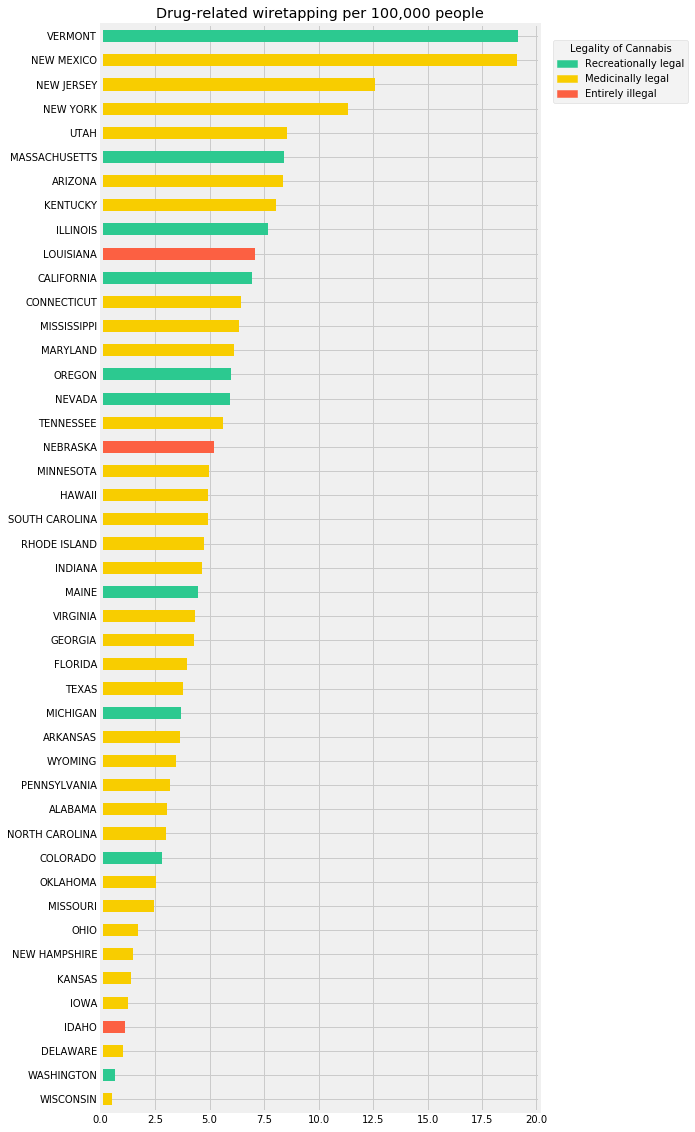

In [24]:
ax = drugs.sort_values(by='per_capita').plot(kind='barh', x='NAME', y='per_capita', figsize=(7, 20), color=colors, legend=True)
ax.set_ylabel('')
ax.set_title('Drug-related wiretapping per 100,000 people')

green_color = mpatches.Patch(color='#2CC990', label='Recreationally legal')
gold_color = mpatches.Patch(color='#F8CD00', label='Medicinally legal')
red_color = mpatches.Patch(color='#FC6042', label='Entirely illegal')


ax.legend(handles=[green_color, gold_color, red_color], bbox_to_anchor=(1.02, .99), title='Legality of Cannabis')

plt.savefig('images/drugs_per_state_per_capita.pdf', bbox_inches="tight", transparent=True)

## Exporting it for QGIS mapping
`Choropleths inbound`

In [25]:
records.to_csv("data/collated/records.csv", index=False)

## What offenses makes up those wiretaps?

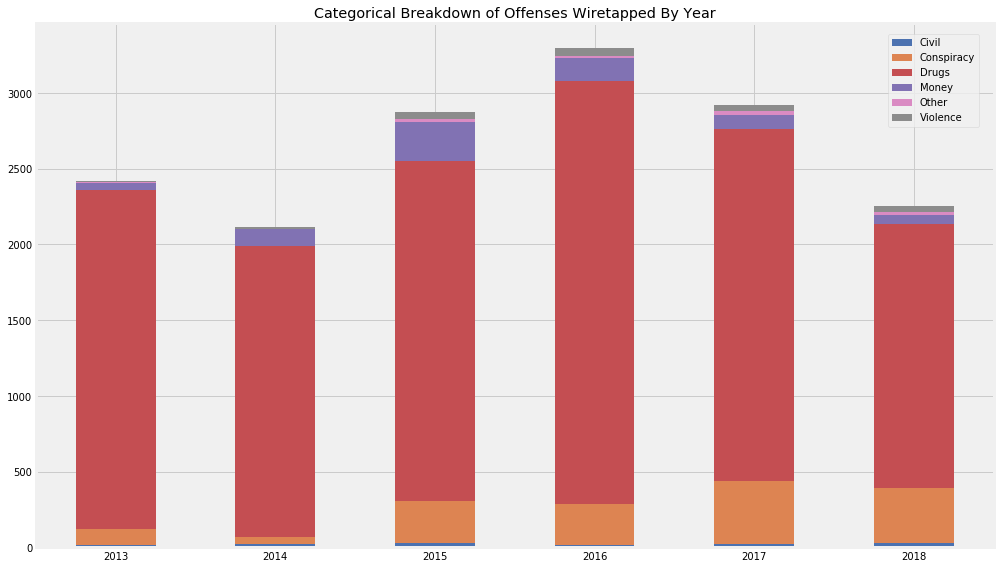

In [26]:
ax = records.groupby(by='year').category.value_counts().unstack('category').plot(kind='bar', stacked=True, figsize=(14,8), colormap=ListedColormap(sns.color_palette("deep", 8)))
ax.legend(bbox_to_anchor=(.99, .99))
ax.set_xlabel('')
ax.set_title('Categorical Breakdown of Offenses Wiretapped By Year')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('images/categorical_breakdown_by_year.pdf')

In [32]:
%matplotlib notebook
title = 'Heroin Overdoses'
d = records.groupby(by='year').category.value_counts().unstack('category')
x = np.array(d.index)
y = np.array(d['Heroin Overdoses'])
overdose = pd.DataFrame(y,x)
#XN,YN = augment(x,y,10)
#augmented = pd.DataFrame(YN,XN)
overdose.columns = {title}

KeyError: 'Heroin Overdoses'

In [ ]:
ax = records.groupby(by='year').category.value_counts().unstack('category').plot(kind='bar', stacked=True, figsize=(14,8), colormap=ListedColormap(sns.color_palette("deep", 8)))
ax.legend(bbox_to_anchor=(.99, .99))
ax.set_xlabel('')
ax.set_title('Categorical Breakdown of Offenses Wiretapped By Year')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('images/categorical_breakdown_by_year.pdf')

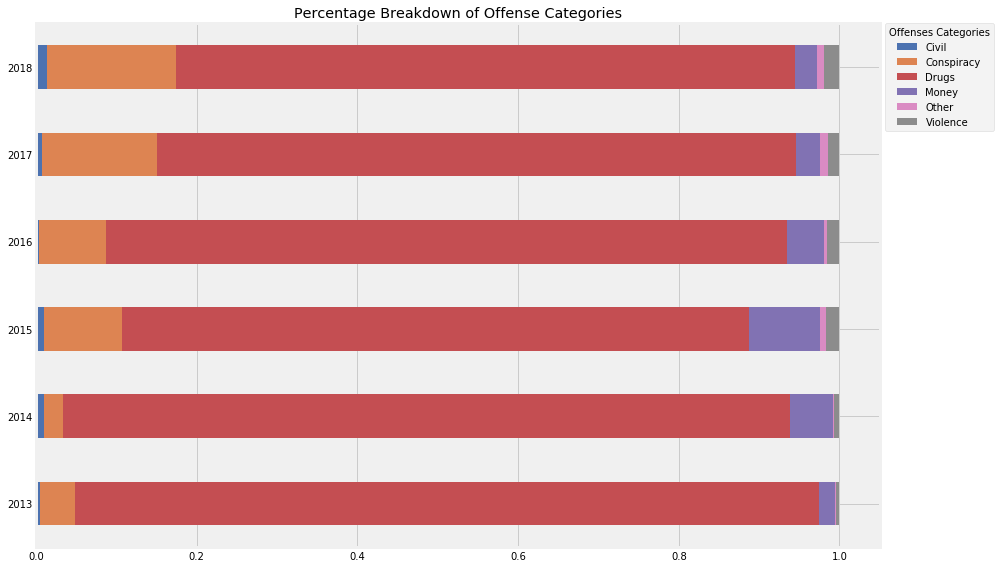

In [27]:
ax = records.groupby(by='year').category.value_counts(normalize=True).unstack('category').plot(kind='barh', stacked=True, figsize=(14, 8), colormap=ListedColormap(sns.color_palette("deep", 8)))
ax.legend(bbox_to_anchor=(1, 1.01), title='Offenses Categories')
ax.set_title('Percentage Breakdown of Offense Categories')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('images/normalized_breakdown_by_year.pdf')

`Narcotics consumes a large portion of annual wiretaps, though it has declined recently`

## Drugs seems like a hotspot for wiretapping. How does it look?

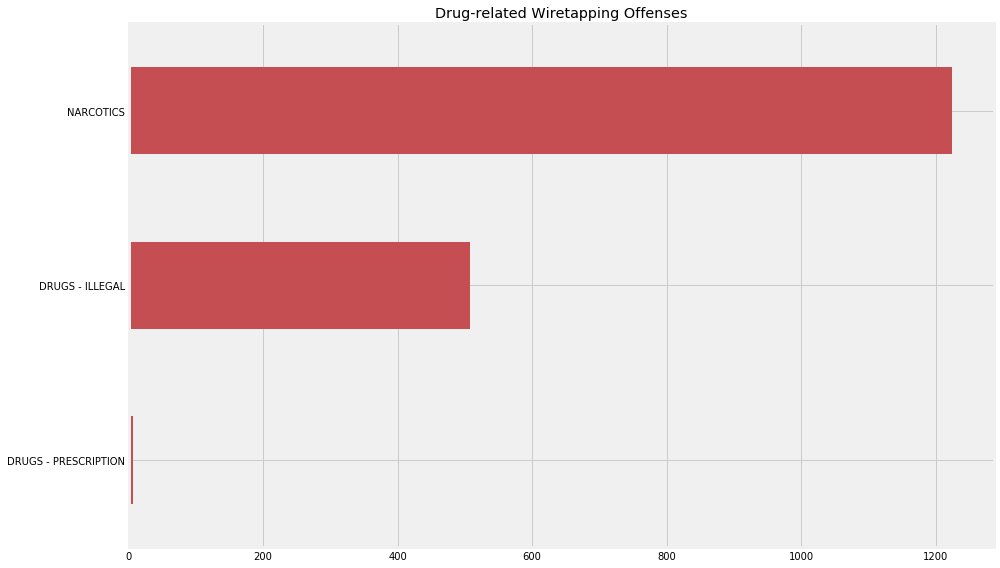

In [28]:
records[(records['category'] == 'Drugs') & (records['year'] == '2018')].Offense.value_counts().head(7).sort_values().plot(kind='barh', title='Drug-related Wiretapping Offenses', figsize=(14,8), color='#C44E52')

plt.tight_layout()
plt.savefig('images/total_drug_offense_breakdown.pdf')

In [29]:
## What does the change between the years look like?

before = 0
years = []
for row in records[records['Offense'] == 'NARCOTICS'].year.value_counts().sort_index():
    this = {}
    new = before - row
    years.append(new)
    before = row

years

[-2238, 322, -286, -122, 526, 573]

In [30]:
records['Arrests'] = records['Arrests'].astype(float)
records['Total Cost($)'] = records['Total Cost($)'].astype(float)
records['Persons Convicted'] = records['Persons Convicted'].astype(float)
records['Avg. Intercepts Per Day'] = records['Avg. Intercepts Per Day'].astype(float)
records['Total Length (Days)'] = records['Total Length (Days)'].astype(float)

# What was 2018's most expensive drug-related wiretapping?

In [31]:
records.category.value_counts()

Drugs         13252
Conspiracy     1483
Money           719
Violence        205
Civil           128
Other            90
Name: category, dtype: int64

In [32]:
records = records.merge(drugs, left_on='state', right_on='NAME')
# records.state.value_counts() / re['POPESTIMATE2018']
# .plot(kind='barh', figsize=(7, 15), title='Wiretapping per state')

In [33]:
records[records.category == 'Drugs'].groupby(by='year')['Total Cost($)'].max()

year
2013    1229649.0
2014     891580.0
2015    1847352.0
2016    5558129.0
2017    5266558.0
2018    1074600.0
Name: Total Cost($), dtype: float64

## Isolating 2018 drug incidents

In [36]:
drug2018 = records[(records.year == '2018') & (records.category == 'Drugs')]

## 2018 Arrests per state

In [47]:
arrests = drug2018.groupby(by='state')['Arrests'].sum().sort_values().iloc[::-1].reset_index()

In [38]:
def legal_colors(x):
    if x.isin(['ALASKA','CALIFORNIA','COLORADO','ILLINOIS','MAINE','MASSACHUSETTS','MICHIGAN','NEVADA','OREGON','VERMONT','WASHINGTON']).state == True:
        return '#2CC990'
    elif x.isin(['ALABAMA','ARIZONA','ARKANSAS','CONNECTICUT','DELAWARE','FLORIDA', 'GEORGIA','HAWAII','INDIANA','IOWA','KANSAS','KENTUCKY','LOUSIANA','MARYLAND','MINNESOTA','MISSISSIPPI','MISSOURI','MONTANA','NEW HAMPSHIRE','NEW JERSEY','NEW MEXICO','NEW YORK','NORTH CAROLINA','NORTH DAKOTA','OHIO','OKLAHOMA','PENNSYLVANIA','RHODE ISLAND','UTAH','SOUTH CAROLINA','TENNESSEE','TEXAS','UTAH','VIRGINIA','WEST VIRGINIA','WISCONSIN','WYOMING']).state == True:
        return '#F8CD00'
    else:
        return '#FC6042'

colors = arrests.sort_values(by='Arrests').apply(legal_colors, axis=1)
colors.head()

44    #F8CD00
43    #F8CD00
42    #F8CD00
41    #F8CD00
40    #F8CD00
dtype: object

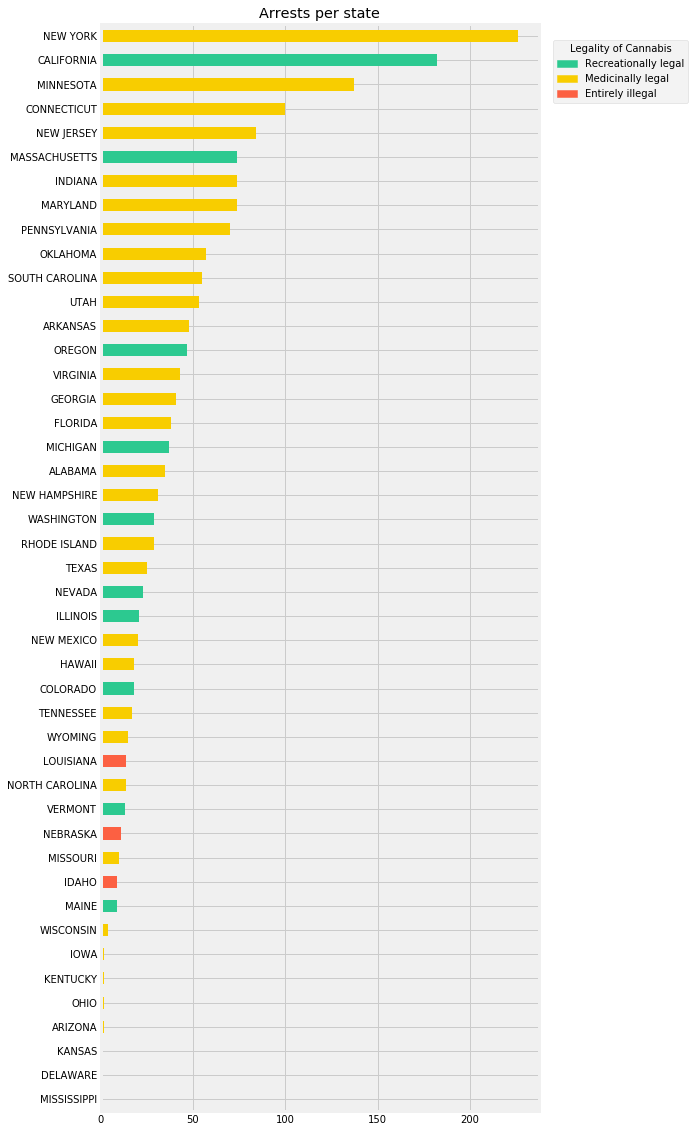

In [39]:
ax = arrests.sort_values(by='Arrests').plot(kind='barh', x='state', y='Arrests', figsize=(7, 20), color=colors, legend=True)
ax.set_ylabel('')
ax.set_title('Arrests per state')

green_color = mpatches.Patch(color='#2CC990', label='Recreationally legal')
gold_color = mpatches.Patch(color='#F8CD00', label='Medicinally legal')
red_color = mpatches.Patch(color='#FC6042', label='Entirely illegal')


ax.legend(handles=[green_color, gold_color, red_color], bbox_to_anchor=(1.02, .99), title='Legality of Cannabis')

plt.savefig('images/drugs_2018_arrested.pdf', bbox_inches="tight")

## 2018 Convictions per state

In [40]:
convictions = drug2018.groupby(by='state')['Persons Convicted'].sum().sort_values().iloc[::-1].reset_index()
convictions.shape

(45, 2)

In [41]:
def legal_colors(x):
    if x.isin(['ALASKA','CALIFORNIA','COLORADO','ILLINOIS','MAINE','MASSACHUSETTS','MICHIGAN','NEVADA','OREGON','VERMONT','WASHINGTON']).state == True:
        return '#2CC990'
    elif x.isin(['ALABAMA','ARIZONA','ARKANSAS','CONNECTICUT','DELAWARE','FLORIDA', 'GEORGIA','HAWAII','INDIANA','IOWA','KANSAS','KENTUCKY','LOUSIANA','MARYLAND','MINNESOTA','MISSISSIPPI','MISSOURI','MONTANA','NEW HAMPSHIRE','NEW JERSEY','NEW MEXICO','NEW YORK','NORTH CAROLINA','NORTH DAKOTA','OHIO','OKLAHOMA','PENNSYLVANIA','RHODE ISLAND','UTAH','SOUTH CAROLINA','TENNESSEE','TEXAS','UTAH','VIRGINIA','WEST VIRGINIA','WISCONSIN','WYOMING']).state == True:
        return '#F8CD00'
    else:
        return '#FC6042'

colors = convictions.sort_values(by='Persons Convicted').apply(legal_colors, axis=1)
colors.head()

22    #2CC990
24    #F8CD00
25    #2CC990
26    #2CC990
27    #F8CD00
dtype: object

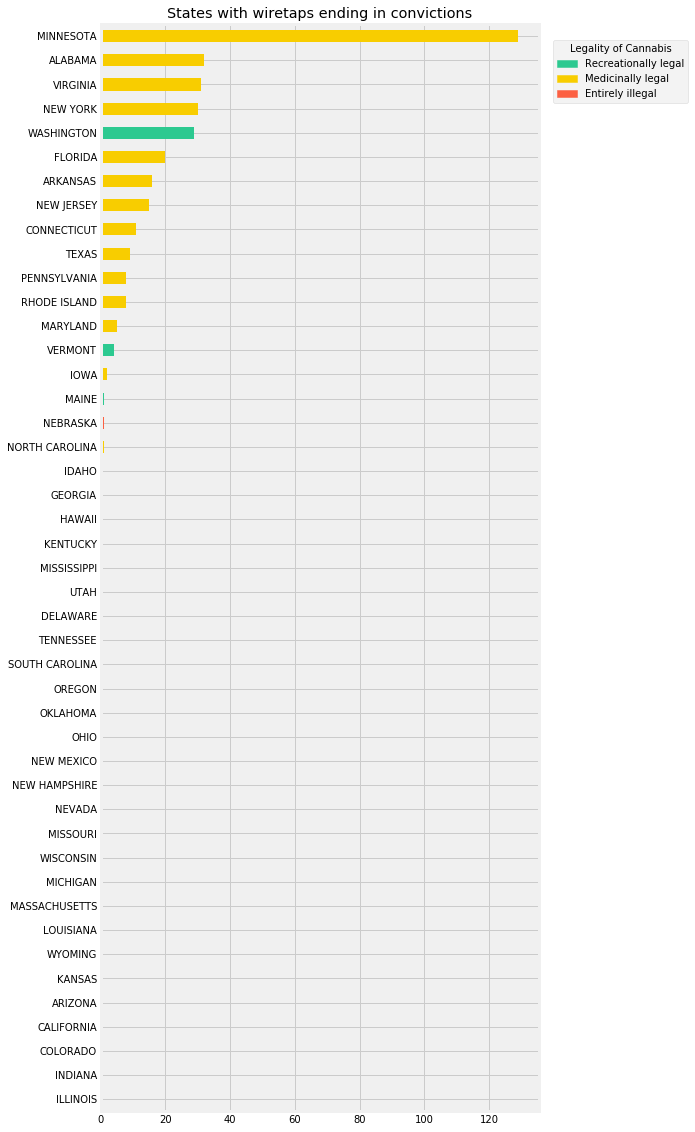

In [42]:
ax = convictions.sort_values(by='Persons Convicted').plot(kind='barh', x='state', y='Persons Convicted', figsize=(7, 20), color=colors, legend=True)
ax.set_ylabel('')
ax.set_title('States with wiretaps ending in convictions')

green_color = mpatches.Patch(color='#2CC990', label='Recreationally legal')
gold_color = mpatches.Patch(color='#F8CD00', label='Medicinally legal')
red_color = mpatches.Patch(color='#FC6042', label='Entirely illegal')


ax.legend(handles=[green_color, gold_color, red_color], bbox_to_anchor=(1.02, .99), title='Legality of Cannabis')

plt.savefig('images/drugs_2018_convicted.pdf', bbox_inches="tight")

## 2018 Total Cost per state

In [43]:
cost = drug2018.groupby(by='state')['Total Cost($)'].sum().sort_values().iloc[::-1].reset_index()
cost.head()

,state,Total Cost($)
0,NEW YORK,10990146.0
1,CALIFORNIA,6423671.0
2,NEW JERSEY,3393610.0
3,TEXAS,2819527.0
4,VIRGINIA,2674226.0


In [44]:
def legal_colors(x):
    if x.isin(['ALASKA','CALIFORNIA','COLORADO','ILLINOIS','MAINE','MASSACHUSETTS','MICHIGAN','NEVADA','OREGON','VERMONT','WASHINGTON']).state == True:
        return '#2CC990'
    elif x.isin(['ALABAMA','ARIZONA','ARKANSAS','CONNECTICUT','DELAWARE','FLORIDA', 'GEORGIA','HAWAII','INDIANA','IOWA','KANSAS','KENTUCKY','LOUSIANA','MARYLAND','MINNESOTA','MISSISSIPPI','MISSOURI','MONTANA','NEW HAMPSHIRE','NEW JERSEY','NEW MEXICO','NEW YORK','NORTH CAROLINA','NORTH DAKOTA','OHIO','OKLAHOMA','PENNSYLVANIA','RHODE ISLAND','UTAH','SOUTH CAROLINA','TENNESSEE','TEXAS','UTAH','VIRGINIA','WEST VIRGINIA','WISCONSIN','WYOMING']).state == True:
        return '#F8CD00'
    else:
        return '#FC6042'

colors = cost.sort_values(by='Total Cost($)').apply(legal_colors, axis=1)
colors.head()

44    #F8CD00
43    #F8CD00
42    #FC6042
41    #F8CD00
40    #2CC990
dtype: object

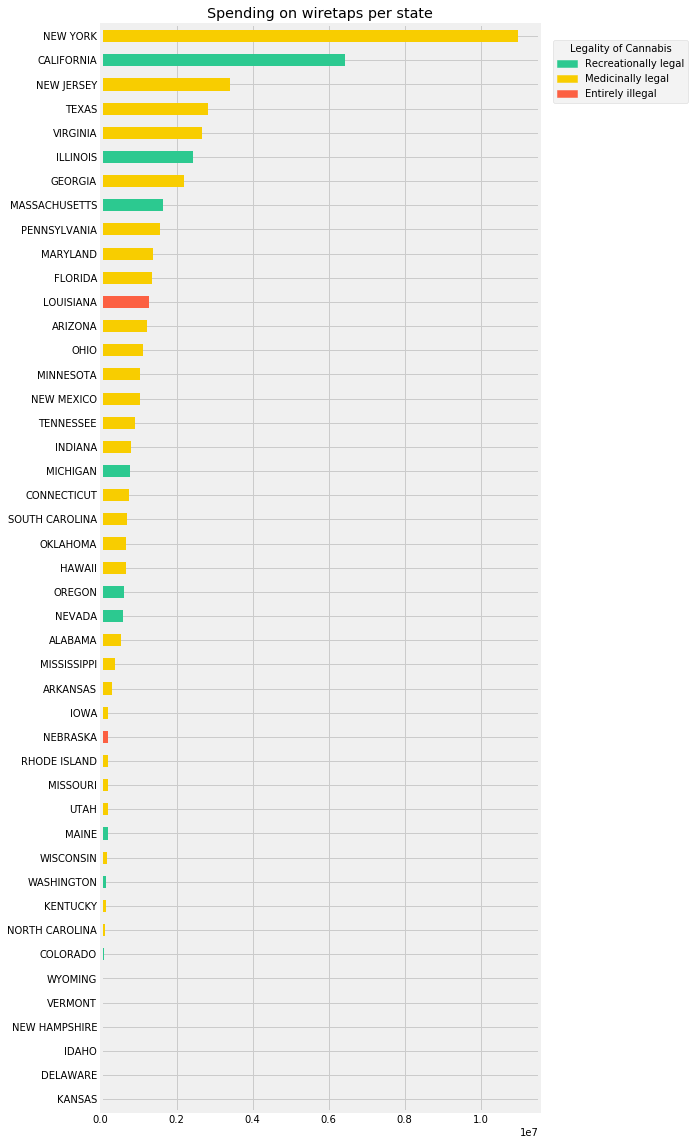

In [45]:
ax = cost.sort_values(by='Total Cost($)').plot(kind='barh', x='state', y='Total Cost($)', figsize=(7, 20), color=colors, legend=True)
ax.set_ylabel('')
ax.set_title('Spending on wiretaps per state')

green_color = mpatches.Patch(color='#2CC990', label='Recreationally legal')
gold_color = mpatches.Patch(color='#F8CD00', label='Medicinally legal')
red_color = mpatches.Patch(color='#FC6042', label='Entirely illegal')


ax.legend(handles=[green_color, gold_color, red_color], bbox_to_anchor=(1.02, .99), title='Legality of Cannabis')

plt.savefig('images/drugs_2018_cost.pdf', bbox_inches="tight")